In [1]:
%load_ext autoreload
%autoreload 2
%run pf_data.py '../pflotran_model/hydrothermal.nc'

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [2]:
# Parameters
basecase = 4
time = 1000
pf_data = pf_data.sel(file_number=basecase)

In [3]:
print(f"High T: {pf_data['percentage_alteration'].sel(time=time).where(pf_data['Temperature'] > 250).mean().values} ± {pf_data['percentage_alteration'].sel(time=time).where(pf_data['Temperature'] > 250).std().values}")
print(f"Low T: {pf_data['percentage_alteration'].sel(time=time).where(pf_data['Temperature'] < 250).mean().values} ± {pf_data['percentage_alteration'].sel(time=time).where(pf_data['Temperature'] < 250).std().values}")
print(f"Max alteration in 150-250 region: {pf_data['percentage_alteration'].sel(time=time).where((pf_data['Temperature'] < 250) & (pf_data['Temperature']> 150)).max().values}")

High T: 15.69506858331649 ± 6.201836791700503
Low T: 0.2566254264268534 ± 0.7452775594383139
Max alteration in 150-250 region: 5.49931362960389


In [4]:
def stack_plot(ax, ds, variable_groups, crunchtope=False):
    import numpy as np

    variables = []
    for variable_group in variable_groups: 
        for minerals in variable_group.keys():
            if crunchtope:
                variables.extend([minerals])
                primary_minerals_vol_name = 'primary_minerals'
            else:
                variables.extend([minerals + "_VF"])
                primary_minerals_vol_name = 'primary_minerals' + "_VF"

    # Condition to sum over a part of the domain, based on another variable 'condition_var'
    # For example, let's sum where 'condition_var' is greater than a threshold value

    #ax.set_prop_cycle(custom_cycler)
    
    threshold = 0
    condition = ds['percentage_alteration'].sel(time=time, method='nearest') > threshold

    mean_alteration = ds['percentage_alteration'].sel(time=time, method='nearest').where(condition).mean().values
    ax.annotate(f'Mean percentage alteration in region: {mean_alteration:.2f}%', xy=(0.95, 0.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')


    if crunchtope:
        dims=['X', 'Z', 'Y']
    else:
        dims=['x', 'z', 'y']

    normalised = condition.sum(dim=dims)
    # Calculate the sum of each variable over the specified condition
    sums = {}
    for var in variables:
        sums[var] = ds[var].where(condition).sum(dim=dims) / ds['secondary_minerals_VF'].where(condition).sel(time=time).sum(dims) * 100 # Assuming 'x' and 'y' are spatial dimensions

    # Strip last three characters and capitalize the first word
    labels = [string[:-3].capitalize() for string in variables] 

    # Convert the sums into a stack plot
    # Assuming 'time' is the dimension you want to plot over
    stack_data = np.vstack([sums[var].values for var in variables])
    ax.stackplot(ds['time'], stack_data, labels=labels)

    return ax

/var/folders/86/d5n0l2wj5yn0p84q_4jzm_6r0000gn/T/ipykernel_3873/1280176368.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


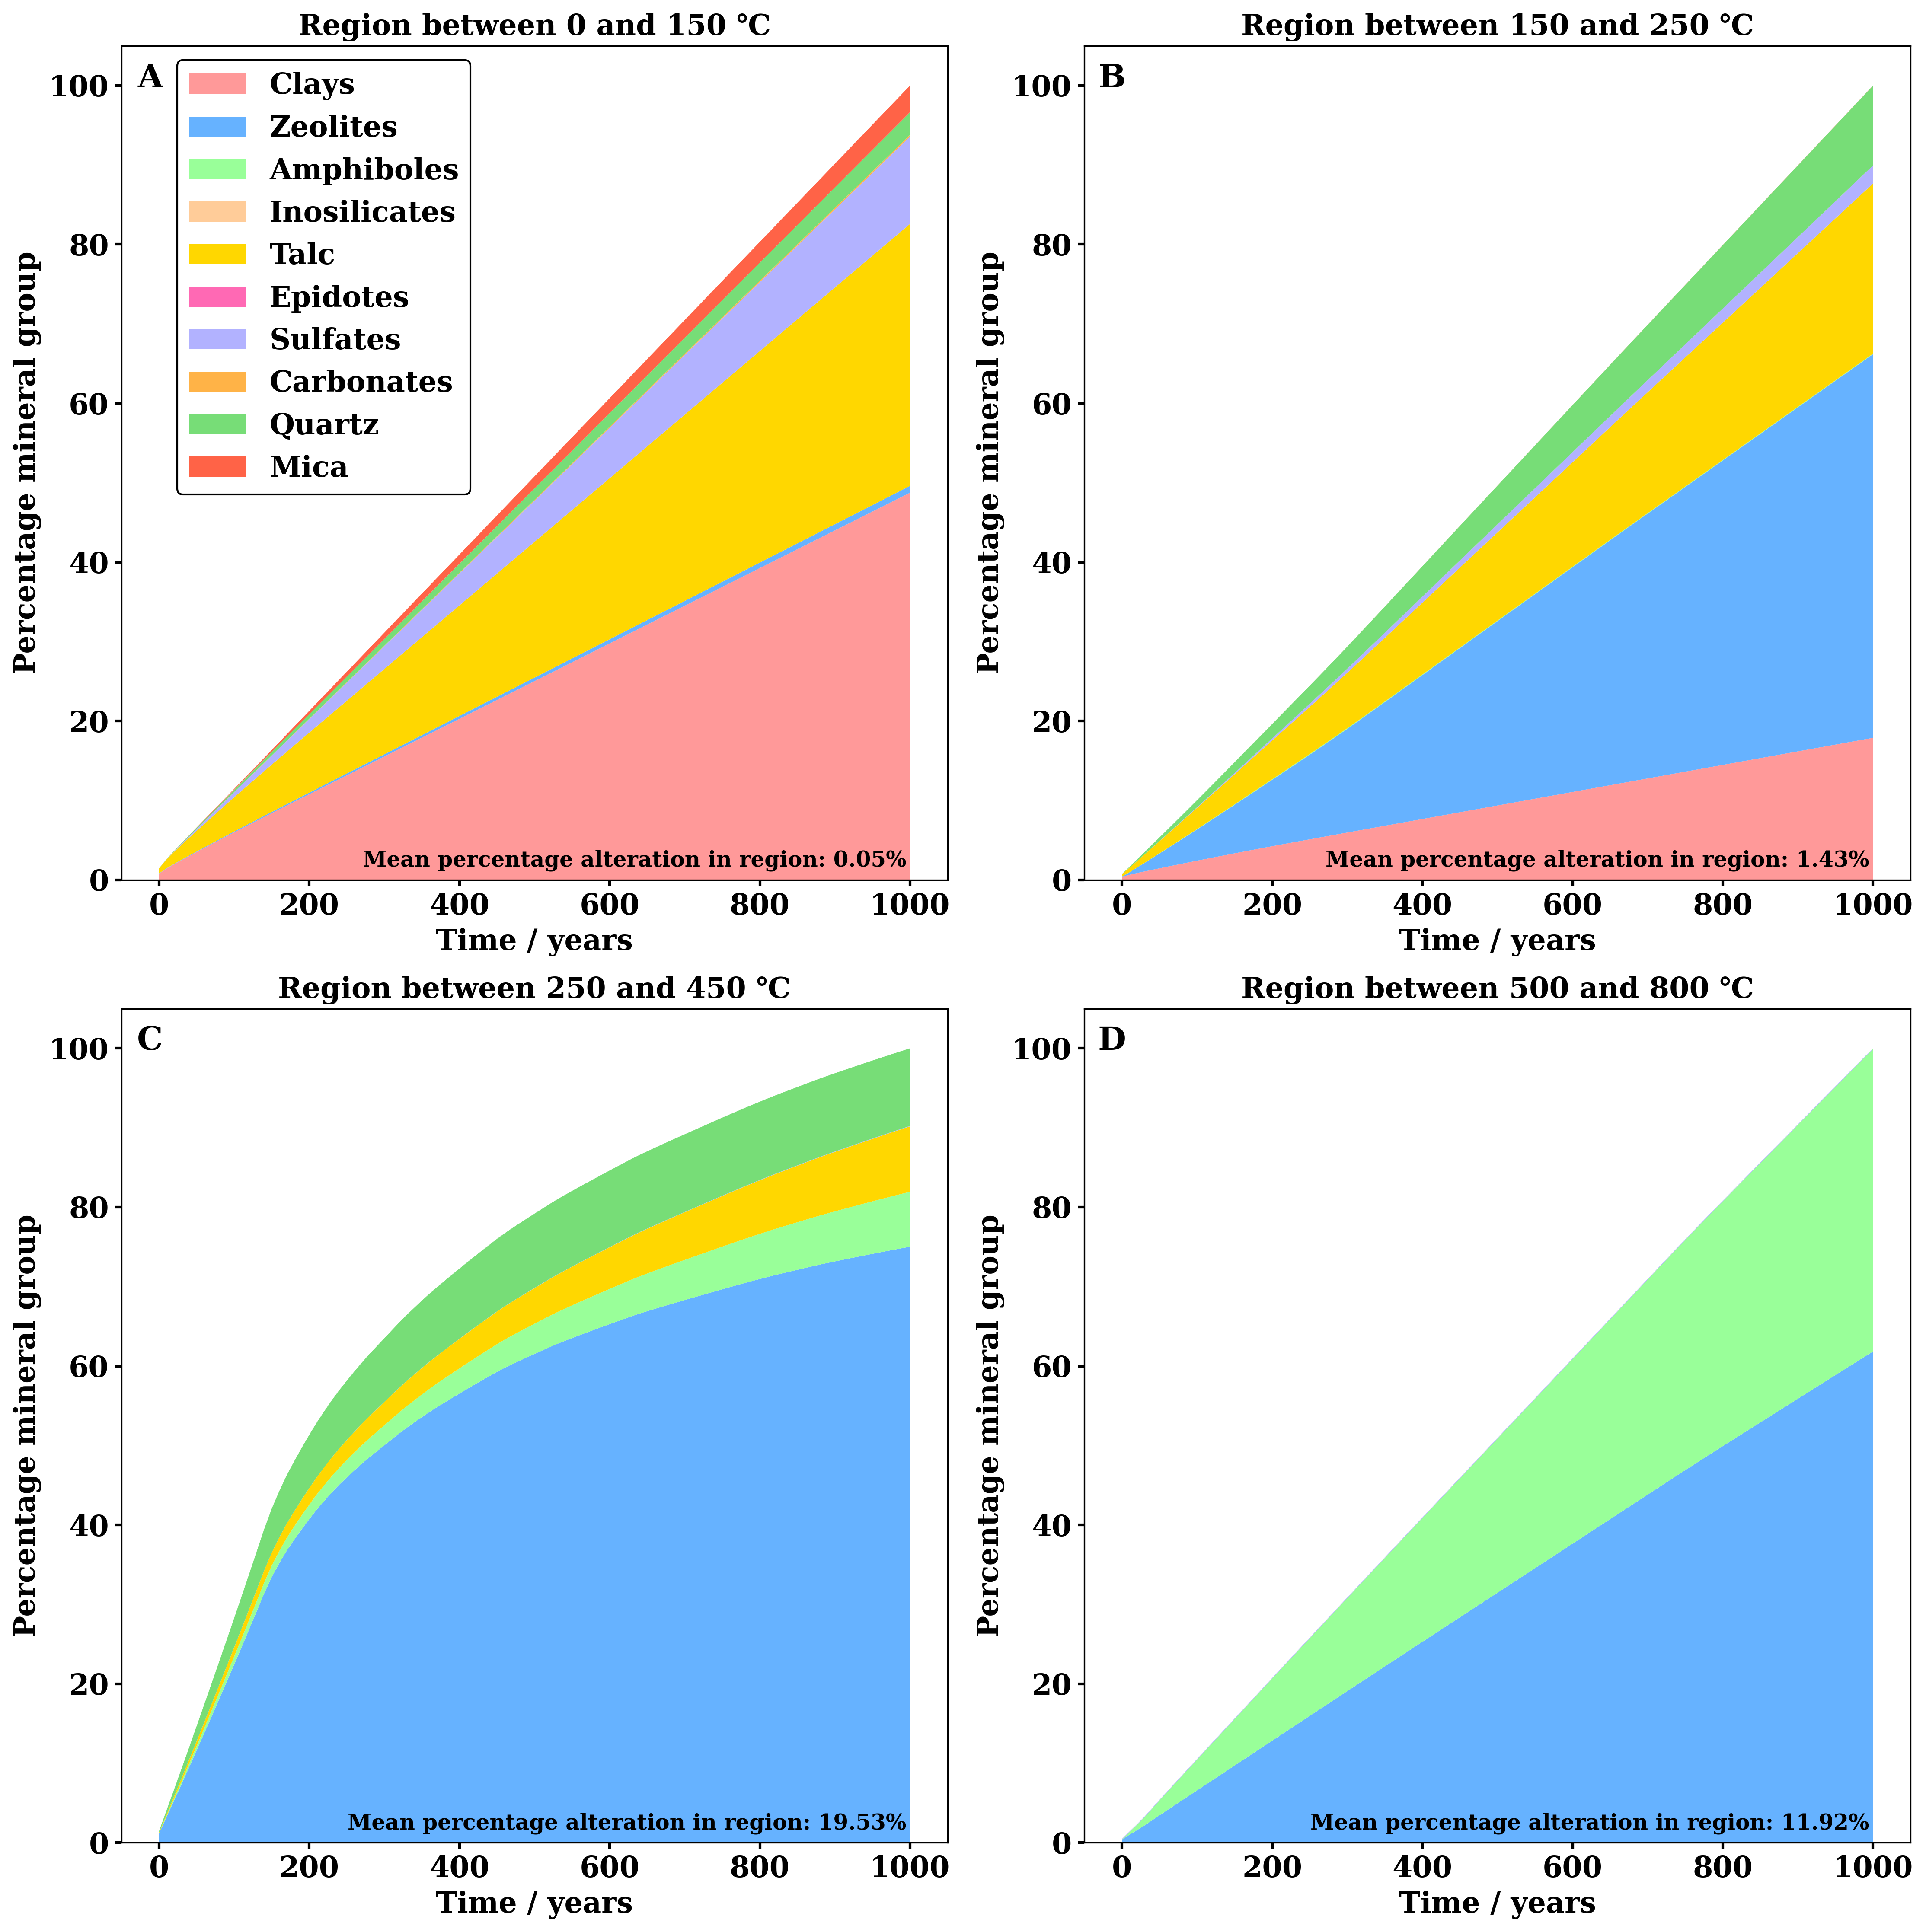

In [5]:
from matplotlib import pyplot as plt
from matplotlib import cycler
import numpy as np
import figures as figs
import cmcrameri.cm as cm

# Set custom style and font size
plt.style.use('custom.mplstyle')
fontsize = 16

# Create figure and axis array for subplots (3 rows, 2 columns)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

# List of identifying capital letters for each subplot
subplot_labels = ['A', 'B', 'C', 'D']

# Temperature region plots with bounds
bounds = [[0, 150], [150, 250], [250, 450], [500, 800]]
for axis, bound, label in zip(ax[0:4], bounds, subplot_labels):
    lower, upper = bound
    condition = (pf_data['Temperature'] >= lower) & (pf_data['Temperature'] <= upper)
    
    # Plot stack plots for secondary mineral groups
    stack_plot(axis, pf_data.where(condition), [secondary_mineral_groups])
    
    axis.set_xlabel('Time / years', fontsize=fontsize)
    axis.set_ylabel('Percentage mineral group', fontsize=fontsize)
    axis.set_title(f'Region between {lower} and {upper} ℃', fontsize=fontsize)

# Add legend to the third plot
ax[0].legend(bbox_to_anchor=(0.05, 1), loc='upper left', fontsize=fontsize)


# Add identifying letters to each subplot
for i, axis in enumerate(ax):
    axis.text(0.05, 0.98, subplot_labels[i], transform=axis.transAxes, 
              fontsize=18, fontweight='bold', va='top', ha='right')

# Adjust layout and save the figure
fig.tight_layout()
fig.savefig('output/figure_3.png', dpi=300)
fig.show()
